In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ust_wildfire.regression import powerlaw_fit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress

In [3]:
df_ca = pd.read_csv("../data/california.csv")
df_ca = df_ca.dropna(subset=["size"])
df_ca = df_ca[(df_ca["year"].isin(np.arange(1950, 2021)))]

df_ab = pd.read_csv("../data/alberta.csv")
df_ab = df_ab.dropna(subset=["size"])
df_ab = df_ab[(df_ab["year"].isin(np.arange(1983, 2018)))]

bins = np.logspace(-2, 5, num=15, base=10)
edges = (bins[:-1] + bins[1:]) / 2
centers = bins[1:-1]

In [4]:
hist1, _ = np.histogram(df_ca["size"], bins=edges, density=True)
hist2, _ = np.histogram(df_ab["size"], bins=edges, density=True)

ind1 = np.nonzero(hist1)
ind2 = np.nonzero(hist2)

As explained in the readme, we want to establish a link between wildfire size distribution and the climate. This is motivated by the power-law behavior of wildfire size distribution. So let's check whether this power-law behavior is really there. A power law distribution has the mathematical form $P(A) \sim A^{\alpha}$, so in a log-log plot, a power-law tail will appear as a straight line. 

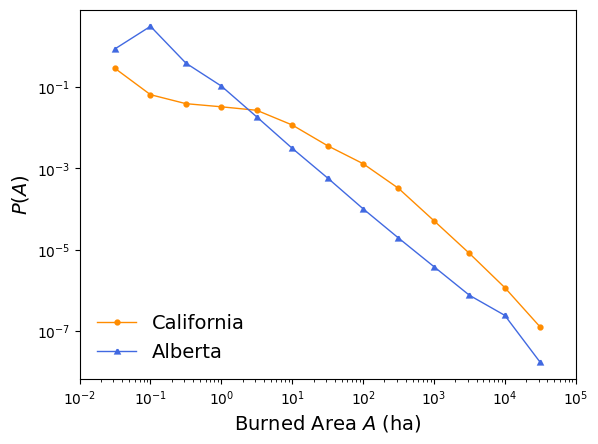

In [6]:
fig, ax = plt.subplots()

ax.plot(centers[ind1], hist1[ind1],
        marker="o", ms=3, color="darkorange",
        linestyle="-", linewidth=1, markeredgewidth=1.5,
        label="California")

ax.plot(centers[ind2], hist2[ind2],
        marker="^", ms=3, color="royalblue",
        linestyle="-", linewidth=1, markeredgewidth=1.5,
        label="Alberta")

ax.set_xlim(1e-2, 1e5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(frameon=False, loc="lower left", fontsize=14)

ax.set_xlabel("Burned Area $A$ (ha)", fontsize=14)
ax.set_ylabel("$P(A)$", fontsize=14)

plt.show()

To proceed, let's group the wildfire events according to their start-time temperature and examine the size distribution in each temperature group. Let's start with the California fires.

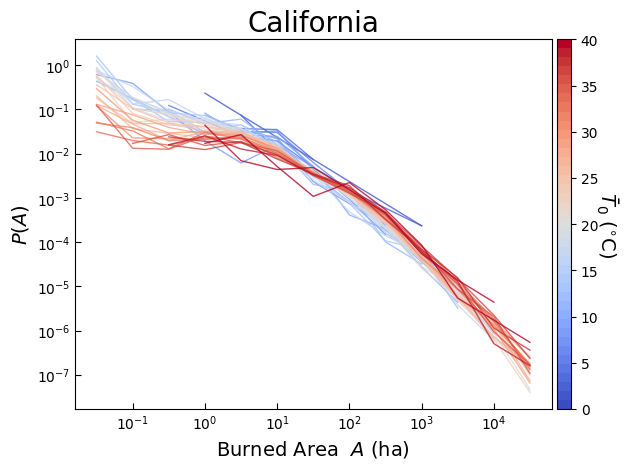

In [13]:
fig, ax = plt.subplots()

temp_axis = np.arange(0, 41)
cmap = plt.get_cmap("coolwarm", len(temp_axis))

for i, t in enumerate(temp_axis):
        df_sub = df_ca[df_ca["temp_st"].between(t, t + 1)]
        hist, _ = np.histogram(df_sub["size"], bins=edges, density=True)

        ind = np.nonzero(hist)
        ax.plot(centers[ind], hist[ind], color=cmap(i + 1),
                lw=1, alpha=0.8)


ax.set_title("California", fontsize=20)
ax.set_xlabel("Burned Area $\ A$ (ha)", fontsize=14)
ax.set_ylabel("$P(A)$", fontsize=14)

ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=4, labelsize=10)
ax.tick_params(which="minor", length=0)
ax.set_yscale("log")
ax.set_xscale("log")


# Create color bar
scat = ax.scatter([], [], c=[], cmap=cmap, vmin=0, vmax=40)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar = fig.colorbar(scat, cax=cax, orientation='vertical')

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r"$\bar{T}_0$ ($^{\circ}$C)", rotation=270, fontsize=14)


plt.show()

The power-law index $\alpha$ can be extracted by a linear fit of the tail of the distribution curves in log-log space. However, the power-law indices extracted this way does not seem to have much relation wit the temperature.

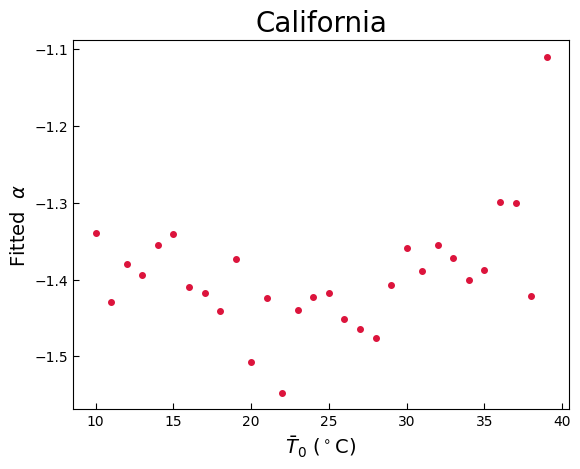

In [14]:
fig, ax = plt.subplots()

temp_axis = np.arange(10, 40)
alpha = np.zeros(len(temp_axis))

for i, t in enumerate(temp_axis):
    df_sub = df_ca[df_ca["temp_st"].between(t, t + 1)]
    hist, _ = np.histogram(df_sub["size"], bins=edges, density=True)

    a, _ = powerlaw_fit(centers, hist, x_range=[1e1, 1e5])
    alpha[i] = a

ax.plot(temp_axis, alpha, marker="o", linestyle="none",
        color="crimson", ms=4)

ax.set_title("California", fontsize=20)
ax.set_xlabel(r"$\bar{T}_0$ ($^\circ$C)", fontsize=14)
ax.set_ylabel(r"Fitted $\ \alpha$", fontsize=14)
ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=4, labelsize=10)


plt.show()

But if we take a closer looks to the distribution curves, we can see that the curves do not really have a pure power-law tail. There is more like a transition in high wildfire size, where the end of the tail are suppressed further. This power-law suppression is actually something natural to expect: For example, people obviously would put a lot more effort to contain extremely large fires, so in practice wildfire can never grow unboundedly following their natural size distribution.

This is of course a hypothesis that needs further evidence to verify, but if we take it to be true, we can find a very clear line relation between the power-law index and the start-time temperature.

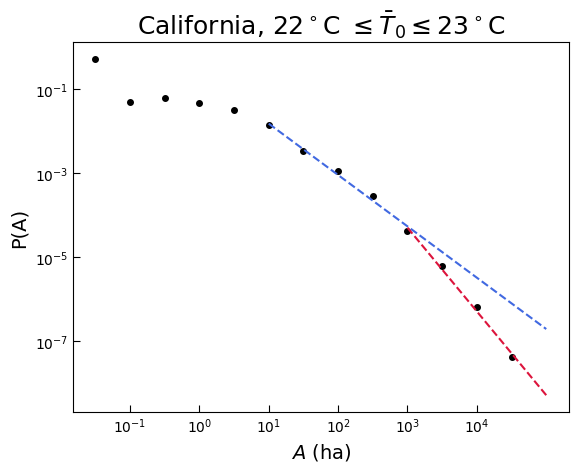

In [20]:
fig, ax = plt.subplots()

df_sub = df_ca[df_ca["temp_st"].between(22, 23)]
hist, _ = np.histogram(df_sub["size"], bins=edges, density=True)

ax.plot(centers, hist, color="black", marker="o", linestyle="none", ms=4)

# The middle range fit
a1, b1 = powerlaw_fit(centers, hist, x_range=[1e1, 1e3])
x1 = np.arange(1e1, 1e5, 0.1)
y1 = b1 * x1 ** a1
ax.plot(x1, y1, color="royalblue", linestyle="dashed")

# The tail fit
a2, b2 = powerlaw_fit(centers, hist, x_range=[1e3, None])
x2 = np.arange(1e3, 1e5, 0.1)
y2 = b2 * x2 ** a2
ax.plot(x2, y2, color="crimson", linestyle="dashed")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks([1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=5, labelsize=10)
ax.tick_params(which="minor", length=0)

ax.set_xlabel("$A$ (ha)", fontsize=14)
ax.set_ylabel("P(A)", fontsize=14)
ax.set_title(r"California, $22^\circ$C $\leq \bar{T}_0 \leq 23^\circ$C", fontsize=18)

plt.show()

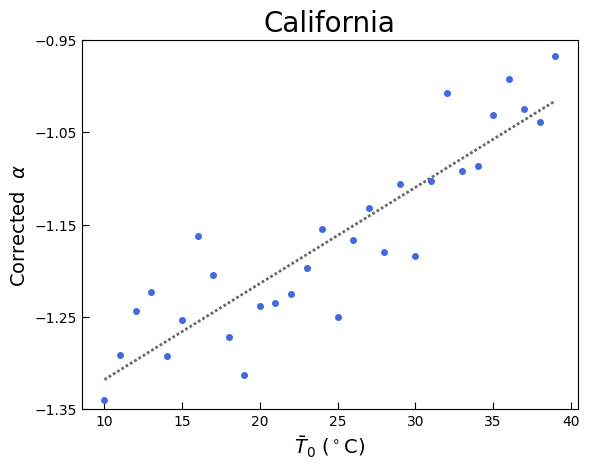

In [25]:
fig, ax = plt.subplots()

temp_axis = np.arange(10, 40)
alpha = np.zeros(len(temp_axis))

for i, t in enumerate(temp_axis):
    df_sub = df_ca[df_ca["temp_st"].between(t, t + 1)]
    hist, _ = np.histogram(df_sub["size"], bins=edges, density=True)

    a, _ = powerlaw_fit(centers, hist, x_range=[1e1, 1e3])
    alpha[i] = a

ax.plot(temp_axis, alpha, marker="o", linestyle="none",
        color="royalblue", ms=4)

m, b, _, _, _ = linregress(temp_axis, alpha)
ax.plot(temp_axis, b + m * temp_axis, linestyle=(0, (1, 0.8)),
        color="dimgrey", lw=2)

ax.set_ylim(-1.35, -0.95)
ax.set_yticks(np.arange(-1.35, -0.95, 0.1))

ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=5, labelsize=10)
ax.tick_params(which="minor", length=0)

ax.set_xlabel(r"$\bar{T}_0$ ($^\circ$C)", fontsize=14)
ax.set_ylabel(r"Corrected $\ \alpha$", fontsize=14)
ax.set_title("California", fontsize=20)

plt.show()

The same analysis can be repeat for the Alberta data. There are not as much power-law suppress problem in Alberta, and we found again a clear linear relation between the power-law index and temperature. Recall we mentioned that there are a non-negligible population of wildfire events below zero degree, and they appear as outlier from the linear relation, probably because of their distinct physical characteristics.

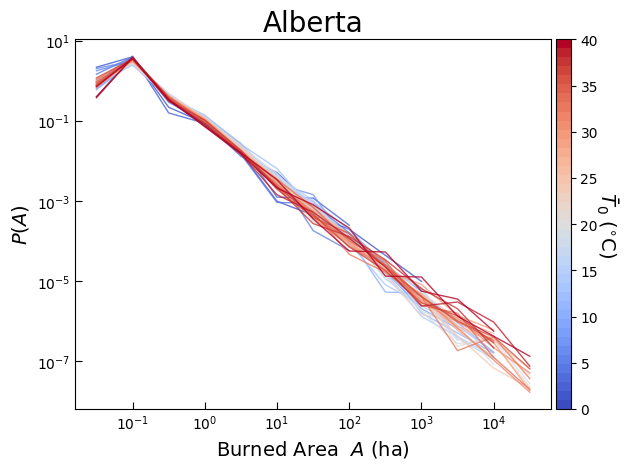

In [28]:
fig, ax = plt.subplots()

temp_axis = np.arange(-10, 31)
cmap = plt.get_cmap("coolwarm", len(temp_axis))

for i, t in enumerate(temp_axis):
        df_sub = df_ab[df_ab["temp_st"].between(t, t + 1)]
        hist, _ = np.histogram(df_sub["size"], bins=edges, density=True)

        ind = np.nonzero(hist)
        ax.plot(centers[ind], hist[ind], color=cmap(i + 1),
                lw=1, alpha=0.8)


ax.set_title("Alberta", fontsize=20)
ax.set_xlabel("Burned Area $\ A$ (ha)", fontsize=14)
ax.set_ylabel("$P(A)$", fontsize=14)

ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=5, labelsize=10)
ax.tick_params(which="minor", length=0)
ax.set_yscale("log")
ax.set_xscale("log")


# Create color bar
scat = ax.scatter([], [], c=[], cmap=cmap, vmin=0, vmax=40)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar = fig.colorbar(scat, cax=cax, orientation='vertical')

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r"$\bar{T}_0$ ($^{\circ}$C)", rotation=270, fontsize=14)


plt.show()

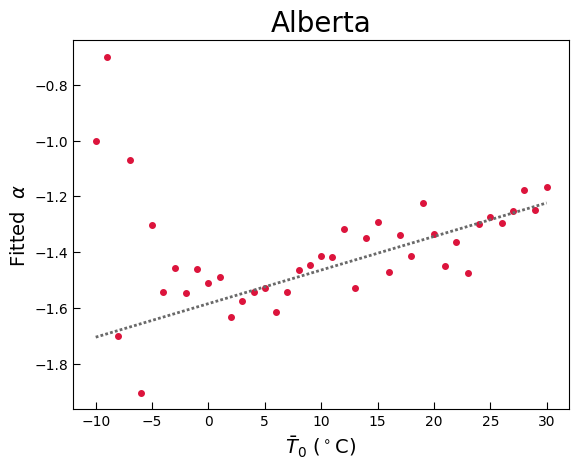

In [31]:
fig, ax = plt.subplots()

temp_axis = np.arange(-10, 31)
alpha = np.zeros(len(temp_axis))

for i, t in enumerate(temp_axis):
    df_sub = df_ab[df_ab["temp_st"].between(t, t + 1)]
    hist, _ = np.histogram(df_sub["size"], bins=edges, density=True)

    a, _ = powerlaw_fit(centers, hist, x_range=[1e1, 1e5])
    alpha[i] = a

ax.plot(temp_axis, alpha, marker="o", linestyle="none",
        color="crimson", ms=4)


# Best fit
ind = np.where(temp_axis > 0)
m, b, _, _, _ = linregress(temp_axis[ind], alpha[ind])
ax.plot(temp_axis, b + m * temp_axis, linestyle=(0, (1, 0.8)),
        color="dimgrey", lw=2)


ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=5, labelsize=10)
ax.tick_params(which="minor", length=0)

ax.set_xlabel(r"$\bar{T}_0$ ($^\circ$C)", fontsize=14)
ax.set_ylabel(r"Fitted $\ \alpha$", fontsize=14)
ax.set_title("Alberta", fontsize=20)

plt.show()